<a href="https://colab.research.google.com/github/Hello-Ni/Chest_Classification/blob/master/NIH_EfficientNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip "drive/MyDrive/DataSet/chest_data.zip"
!unzip "drive/MyDrive/DataSet/NIH_Images.zip" -d NIH_Image

串流輸出內容已截斷至最後 5000 行。
  inflating: NIH_Image/00027093_001.jpg  
  inflating: NIH_Image/00027093_002.jpg  
  inflating: NIH_Image/00027093_003.jpg  
  inflating: NIH_Image/00027093_005.jpg  
  inflating: NIH_Image/00027093_006.jpg  
  inflating: NIH_Image/00027093_007.jpg  
  inflating: NIH_Image/00027094_000.jpg  
  inflating: NIH_Image/00027094_003.jpg  
  inflating: NIH_Image/00027094_006.jpg  
  inflating: NIH_Image/00027094_007.jpg  
  inflating: NIH_Image/00027096_000.jpg  
  inflating: NIH_Image/00027097_001.jpg  
  inflating: NIH_Image/00027100_000.jpg  
  inflating: NIH_Image/00027103_001.jpg  
  inflating: NIH_Image/00027104_001.jpg  
  inflating: NIH_Image/00027104_004.jpg  
  inflating: NIH_Image/00027104_005.jpg  
  inflating: NIH_Image/00027105_000.jpg  
  inflating: NIH_Image/00027105_001.jpg  
  inflating: NIH_Image/00027105_002.jpg  
  inflating: NIH_Image/00027105_003.jpg  
  inflating: NIH_Image/00027107_002.jpg  
  inflating: NIH_Image/00027107_003.jpg  
  inflating: 

In [4]:
import os
import cv2
import time
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader

import torchvision.transforms as T
from torchvision.utils import make_grid
from torchvision.models import resnet50
from sklearn.model_selection import train_test_split

from PIL import Image

import matplotlib.pyplot as plt

In [5]:
df = pd.read_csv('NIH_Dataframe.csv')
df.img_ind=df.img_ind.apply(lambda x:x.split('.')[0])
display(df.head(4))

data=df.values
all_class=df.columns.to_numpy()

,Cardiomegaly,Hernia,Infiltration,Nodule,Emphysema,Effusion,Atelectasis,Pleural_Thickening,Pneumothorax,Mass,Fibrosis,Consolidation,Edema,Pneumonia,img_ind
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,00000001_000
1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,00000001_001
2,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,00000001_002
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,00000003_000


In [6]:
def transforms():
    return T.Compose([
        T.Resize(256),
        T.CenterCrop(224),
        T.RandomRotation(15),
        T.RandomHorizontalFlip(p=0.5),
        T.ToTensor(),
        T.Normalize((0, 0, 0),(1, 1, 1))
    ])

In [7]:
class ChestDataset(Dataset):
    
    def __init__(self, data,mode = "train", transforms = None):
        
        super().__init__()
        self.data = data
        self.mode = mode
        self.transforms = transforms
        
    def __getitem__(self, idx):
        
        image_path = "NIH_Image/"+self.data[idx][-1]+".jpg"
        values= np.delete(self.data[idx],-1,0)
        
        
        ### Reading, converting and normalizing image
        #img = cv2.imread(DIR_TRAIN + image_name, cv2.IMREAD_COLOR)
        #img = cv2.resize(img, (224,224))
        #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        #img /= 255.
        img = Image.open(image_path).convert('RGB')
        img = img.resize((224, 224))
        
        if self.mode == "train" or self.mode == "val":
        
            ### Preparing class label
            label=np.where(values>0)[0][0]
            label = torch.tensor(label).type(torch.LongTensor)

            ### Apply Transforms on image
            img = self.transforms(img)

            return img, label
        
        elif self.mode == "test":
            
            ### Apply Transforms on image
            img = self.transforms(img)

            return img
            
        
    def __len__(self):
        return len(self.data)
    

In [8]:
train_imgs,val_imgs=train_test_split(data,test_size=0.2)

In [9]:
train_dataset=ChestDataset(train_imgs,mode="train",transforms=transforms())
val_dataset=ChestDataset(val_imgs,mode="val",transforms=transforms())

train_data_loader = DataLoader(
    dataset = train_dataset,
    num_workers = 2,
    batch_size = 16,
    shuffle = True
)

val_data_loader = DataLoader(
    dataset = val_dataset,
    num_workers = 2,
    batch_size = 16,
    shuffle = True
)


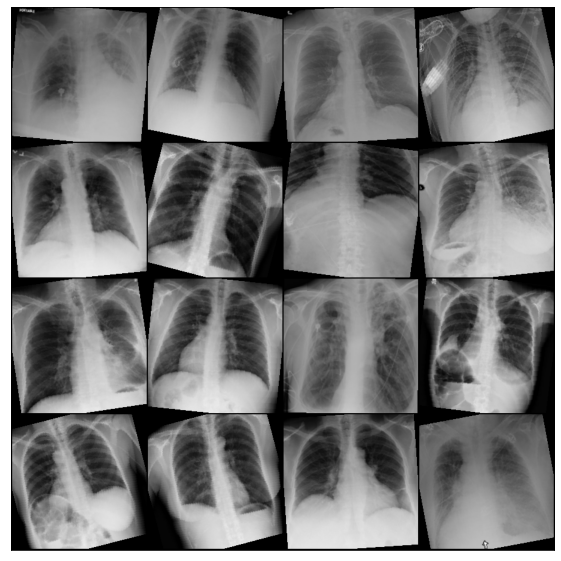

In [10]:
for images, labels in train_data_loader:
    test=labels.reshape(labels.shape[0],1)
    fig, ax = plt.subplots(figsize = (10, 10))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(images, 4).permute(1,2,0))
    break

### Check for GPU availability

In [11]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(torch.cuda.is_available())

True


### Define a function to calculate accuracy

In [12]:
def accuracy(preds, trues):
    
    ### Converting preds to 0 or 1
    preds = [torch.argmax(preds[i]) for i in range(len(preds))]
    ### Calculating accuracy by comparing predictions with true labels
    acc = [1 if preds[i] == trues[i] else 0 for i in range(len(preds))]
    
    ### Summing over all correct predictions
    acc = np.sum(acc) / len(preds)
    
    return (acc * 100)

In [13]:
def train_one_epoch(train_data_loader):
    
    ### Local Parameters
    epoch_loss = []
    epoch_acc = []
    start_time = time.time()
    
    ###Iterating over data loader
    for images, labels in train_data_loader:
        
        #Loading images and labels to device
        images = images.to(device)
        labels = labels.to(device)
        
        #Reseting Gradients
        optimizer.zero_grad()
        
        #Forward
        preds = model(images)
        #Calculating Loss
        _loss = criterion(preds,labels)
        loss = _loss.item()
        epoch_loss.append(loss)
        
        #Calculating Accuracy
        acc = accuracy(preds, labels)
        epoch_acc.append(acc)
        
        #Backward
        _loss.backward()
        optimizer.step()
    
    ###Overall Epoch Results
    end_time = time.time()
    total_time = end_time - start_time
    
    ###Acc and Loss
    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc)
    
    ###Storing results to logs
    train_logs["loss"].append(epoch_loss)
    train_logs["accuracy"].append(epoch_acc)
    train_logs["time"].append(total_time)
        
    return epoch_loss, epoch_acc, total_time
        

In [14]:
def val_one_epoch(val_data_loader, best_val_acc):
    
    ### Local Parameters
    epoch_loss = []
    epoch_acc = []
    start_time = time.time()
    
    ###Iterating over data loader
    for images, labels in val_data_loader:
        
        #Loading images and labels to device
        images = images.to(device)
        labels = labels.to(device)
        
        #Forward
        preds = model(images)
        
        #Calculating Loss
        _loss = criterion(preds,labels)
        loss = _loss.item()
        epoch_loss.append(loss)
        
        #Calculating Accuracy
        acc = accuracy(preds, labels)
        epoch_acc.append(acc)
    
    ###Overall Epoch Results
    end_time = time.time()
    total_time = end_time - start_time
    
    ###Acc and Loss
    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc)
    
    ###Storing results to logs
    val_logs["loss"].append(epoch_loss)
    val_logs["accuracy"].append(epoch_acc)
    val_logs["time"].append(total_time)
    
    ###Saving best model
    if epoch_acc > best_val_acc:
        best_val_acc = epoch_acc
        torch.save(model.state_dict(),"efficient_best.pth")
        
    return epoch_loss, epoch_acc, total_time, best_val_acc

In [15]:
!pip install efficientnet_pytorch
from efficientnet_pytorch import EfficientNet
model = nn.Sequential(
    EfficientNet.from_pretrained('efficientnet-b0'),
    nn.Linear(1000, 14)
)
# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)

# Learning Rate Scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 5, gamma = 0.5)

#Loss Function
criterion = nn.CrossEntropyLoss()

# Logs - Helpful for plotting after training finishes
train_logs = {"loss" : [], "accuracy" : [], "time" : []}
val_logs = {"loss" : [], "accuracy" : [], "time" : []}

# Loading model to device
model.to(device)

# No of epochs 
epochs = 30

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=dceb45d57c30840028d97be30d5e571f15004bc012fa140e0c349cf3bea356f4
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
Successfully built efficientnet-pytorch


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth


  0%|          | 0.00/20.4M [00:00<?, ?B/s]

Loaded pretrained weights for efficientnet-b0


In [16]:
for images,labels in train_data_loader:
  preds=model(images)
  _loss = criterion(preds,labels)
  acc=accuracy(preds,labels)
  print(acc)
  break

RuntimeError: ignored

In [ ]:
best_val_acc = 0
for epoch in range(epochs):
    
    ###Training
    loss, acc, _time = train_one_epoch(train_data_loader)
    
    #Print Epoch Details
    print("\nTraining")
    print("Epoch {}".format(epoch+1))
    print("Loss : {}".format(round(loss, 4)))
    print("Acc : {}".format(round(acc, 4)))
    print("Time : {}".format(round(_time, 4)))
    
    ###Validation
    loss, acc, _time, best_val_acc = val_one_epoch(val_data_loader, best_val_acc)
    
    #Print Epoch Details
    print("\nValidating")
    print("Epoch {}".format(epoch+1))
    print("Loss : {}".format(round(loss, 4)))
    print("Acc : {}".format(round(acc, 4)))
    print("Time : {}".format(round(_time, 4)))
    print("\n===============================================")


Training
Epoch 1
Loss : 1.8788
Acc : 39.5705
Time : 761.23

Validating
Epoch 1
Loss : 1.7879
Acc : 41.5089
Time : 127.5227



In [ ]:
### Plotting Results

#Loss
plt.title("Loss")
plt.plot(np.arange(1, 101, 1), train_logs["loss"], color = 'blue')
plt.plot(np.arange(1, 101, 1), val_logs["loss"], color = 'yellow')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

#Accuracy
plt.title("Accuracy")
plt.plot(np.arange(1, 101, 1), train_logs["accuracy"], color = 'blue')
plt.plot(np.arange(1, 101, 1), val_logs["accuracy"], color = 'yellow')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()